In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
from types import SimpleNamespace

import numpy as np

sys.path.insert(0, "/home/jovyan/pypulseq/src")
import pypulseq as pp

sys.path.insert(0, "/home/jovyan/qrage/src")
from qrage.sequence.qrage import QRAGE

In [2]:
seq_write = False
seq_debug = True
seq_plot = True
seq_calculate_gradient_spectrum = True
seq_check_timing = True
seq_test_report = True
seq_filename = "/home/jovyan/qrage/seq/qrage.seq"

In [3]:
seq = pp.Sequence()

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=200,
    slew_unit="T/m/s",
    rf_ringdown_time=40e-6,
    rf_dead_time=100e-6,
    # adc_dead_time=0,
    adc_dead_time=10e-6,
)

if seq_debug:
    num_spokes = 2
    num_sets = 19
    num_echoes = 9
    num_partitions_per_block = 16
    num_autocalibration_lines = 0
    acceleration_factor = 1
    fov = np.array([256, 256, 16]) * 1e-3
    matrix_size = np.array([256, 256, 16])
    readout_bandwidth = 390.625
else:
    num_spokes = 8
    num_sets = 19
    num_echoes = 9
    num_partitions_per_block = 16
    num_autocalibration_lines = 32
    acceleration_factor = 2
    fov = np.array([256, 256, 160]) * 1e-3
    matrix_size = np.array([256, 256, 160])
    readout_bandwidth = 390.625

axes = SimpleNamespace()

xyz = ["x", "y", "z"]

axes.d1 = "x"  # Readout dimension
axes.d2 = "y"  # Inner phase-encoding loop
axes.d3 = "z"  # Outer phase-enconding loop

axes.n1 = xyz.index(axes.d1)
axes.n2 = xyz.index(axes.d2)
axes.n3 = xyz.index(axes.d3)

In [4]:
seq.set_definition("FOV", fov.tolist())
seq.set_definition("RES", matrix_size.tolist())
seq.set_definition("Name", "QRAGE")

In [5]:
qrage = QRAGE(
    fov,
    matrix_size,
    axes,
    readout_bandwidth,
    num_spokes,
    num_sets,
    num_echoes,
    num_partitions_per_block,
    num_autocalibration_lines,
    acceleration_factor,
    adiabatic_pulse_type="hypsec_n",
    adiabatic_pulse_overdrive=2.0,
    debug=False,
    system=system,
)

/home/jovyan/qrage/src/qrage/sequence/inversion.py:63: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  self.rf180 = make_adiabatic_pulse(
/home/jovyan/qrage/src/qrage/sequence/readout.py:95: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  pp.make_sinc_pulse(
/home/jovyan/qrage/src/qrage/sequence/readout.py:130: UserWarning: Specified ADC delay 0.00 us is less than the dead time 10 us. Delay was increased to the dead time.
  self.adc = pp.make_adc(


In [6]:
qrage.run(seq)

In [7]:
qrage.get_timing(seq)
print(
    "TR %s ms" % np.round(qrage.TR, decimals=1),
    "dTI %s ms" % np.round(qrage.dTI, decimals=1),
    "TI0 %s ms" % np.round(qrage.TI0, decimals=1),
    "dTE %s ms" % np.round(qrage.dTE, decimals=1),
    "TE0 %s ms" % np.round(qrage.TE0, decimals=1),
)

TR 9089.8 ms dTI 477.6 ms TI0 235.1 ms dTE 2.8 ms TE0 3.2 ms


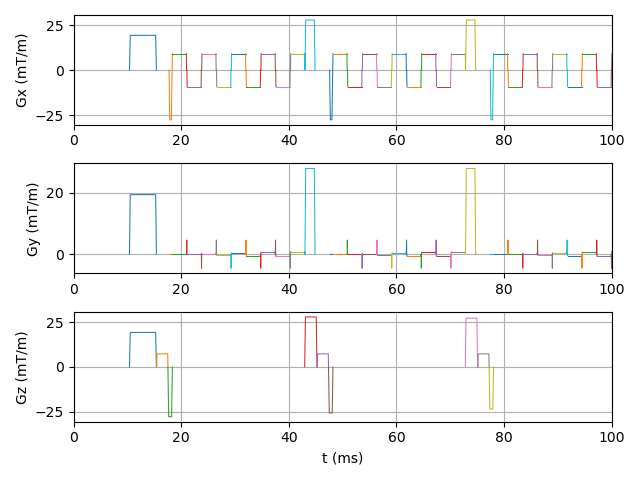

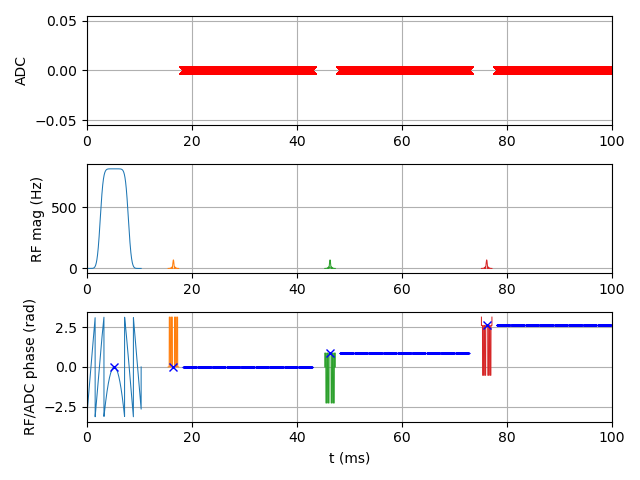

In [8]:
if seq_plot:
    seq.plot(time_range=[0, 0.1], grad_disp="mT/m", time_disp="ms", show_blocks=False)

Resonance frequencies of gradients (x, y, z) are:  [186.66666667 173.33333333  66.66666667]


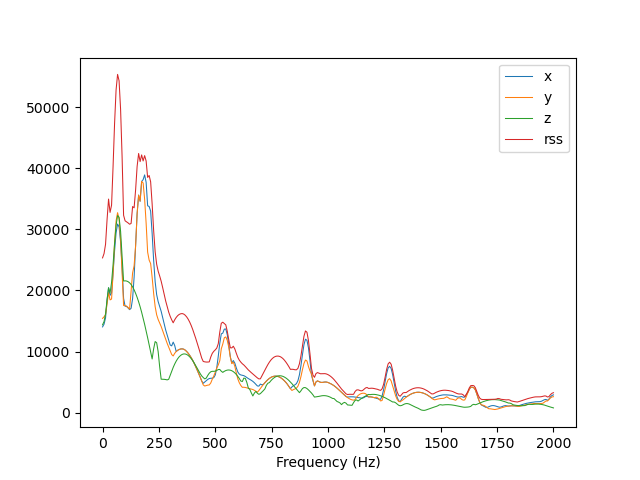

In [9]:
if seq_calculate_gradient_spectrum:
    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum()
    res_freqs = freq[np.argmax(spects, axis=1)]
    print("Resonance frequencies of gradients (x, y, z) are: ", res_freqs)

In [10]:
if seq_check_timing:
    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed")
    else:
        print("Timing check failed")
        [print(e) for e in error_report]

Timing check passed


In [11]:
if seq_test_report:
    rep = seq.test_report()
    print(rep)

Number of blocks: 12206
Number of events:
RF:    610
Gx:  11554
Gy:  11554
Gz:   1826
ADC:   5472
Delay:      0
Sequence duration: 18.179560 s
TE: 0.003165 s
TR: 0.029850 s
Flip angle: 5.00 552.49 deg
Unique k-space positions (aka cols, rows, etc.): 85501 84814 16 
Dimensions: 3
Spatial resolution: 1.00 mm
Spatial resolution: 1.00 mm
Spatial resolution: 1.00 mm
Repetitions/slices/contrasts: 1.0; range: [(np.float64(1.0), np.float64(342.0))]
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Max gradient: 1185345 1185345 1191860 Hz/m == 27.84 27.84 27.99 mT/m
Max slew rate: 8466748769 8466748769 8513289037 Hz/m/s == 198.86 198.86 199.96 T/m/s
Max absolute gradient: 2056846 Hz/m == 48.31 mT/m
Max absolute slew rate: 1.46917e+10 Hz/m/s == 345.07 T/m/s
Event timing check passed successfully



In [12]:
if seq_write:
    seq.write(seq_filename)